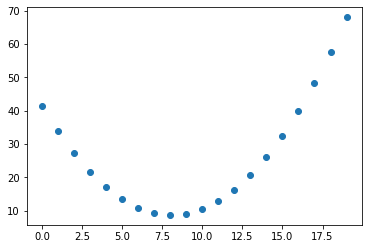

In [1]:
#The graph below of speed takes the form of a quadratic equation i.e "ax^2 + bx + c"

from fastai.vision.all import *

time = torch.arange(0, 20)
speed = 0.5*(time - 9)**2 + 0.9*time + 1

plt.scatter(time, speed)

In [2]:
#Solving the problem for three parameters of the equation before the real deal i.e the mnist data

def f(time, params):
    a,b,c = params
    return a*(time**2) + b*time + c


In [3]:
'''A function that plots a graph of the predictions pred alongside the expected graph for easy 
visualization and follow up of progress while the weights are being updated'''
def show_preds(preds, ax=None):
 if ax is None: ax=plt.subplots()[1]
 ax.scatter(time, speed)
 ax.scatter(time, to_np(preds), color='red')
 ax.set_ylim(-300,100)


In [4]:
#STEP 1: INITIALIZE THE PARAMETERS


'''
Initialize our random numbers making sure their gradients are tracked for updates in the future

requires_grad_() tells pytorch that we want to calculate gradient with respect
to the variable at that value'''
params = torch.randn(3).requires_grad_()
params

tensor([ 1.5350,  0.0895, -0.7681], requires_grad=True)

In [5]:
#STEP 2: CALCULATE THE PREDICTIONS

pred = f(time, params)
pred

tensor([ -0.7681,   0.8565,   5.5511,  13.3158,  24.1505,  38.0554,  55.0302,
         75.0752,  98.1902, 124.3752, 153.6303, 185.9555, 221.3507, 259.8160,
        301.3513, 345.9568, 393.6322, 444.3778, 498.1934, 555.0790],
       grad_fn=<AddBackward0>)

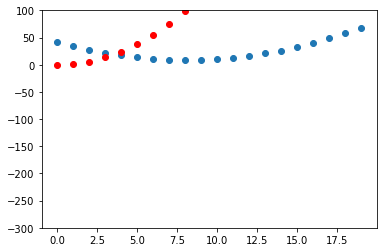

In [6]:
show_preds(pred)

In [7]:
'''loss function that would show us how far we are from the actual/expected graph 
'''
def loss_func(prediction, speed):
    return ((speed-pred)**2).mean().sqrt()

In [8]:
# STEP 3: CALCULATE THE LOSS

'''Using mean squared error instead of "loss_func"'''
loss = mse(pred, speed)
loss

TensorBase(53425.3672, grad_fn=<AliasBackward>)

In [9]:
# STEP 4: CALCULATE THE GRADIENTS


'''Differentiate the loss to calculate gradient(Magnitude and direction calculated from loss function 
that would be used to update the parameters later) at each layer 

"backward" here refers to back propagation, a name given to the process of calculating derivative
at each layer'''
loss.backward()
params.grad.data * 1e-5

tensor([0.7736, 0.0496, 0.0033])

In [10]:
params.data

tensor([ 1.5350,  0.0895, -0.7681])

In [11]:
# STEP 5: STEP THE WEIGHTS

'''Updating the parameters based on the weights we just calculated
'''

lr = 1e-5 #1/100000
params.data -= params.grad*lr
params.data

tensor([ 0.7614,  0.0400, -0.7714])

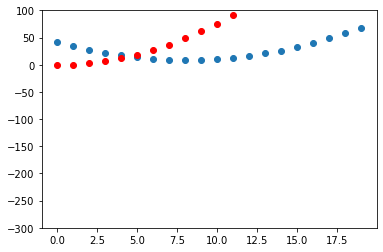

In [12]:
pred = f(time, params)
show_preds(pred)

In [13]:
'''We need to repeat this a few times, so we’ll create a function to apply
one step'''


def apply_step(parameters):
    pred = f(time, parameters)
    loss = mse(pred, speed)
    loss.backward()
    lr = 1e-5
    parameters.data -= parameters.grad*lr
    parameters.grad = None
    print(f"loss: {loss}")
    return pred

In [14]:
#STEP 6: REPEAT THE PROCESS

'''Iterate the stepping until you get a good result

After each iteration the global parameters are altered such that during the next iteration the
apply_step function takes in the updated parameters as input'''

for i in range(2):
    apply_step(params)

loss: 10307.056640625
loss: 7752.5849609375


loss: 1664.366455078125
loss: 512.2874755859375
loss: 294.2767639160156
loss: 253.0204620361328


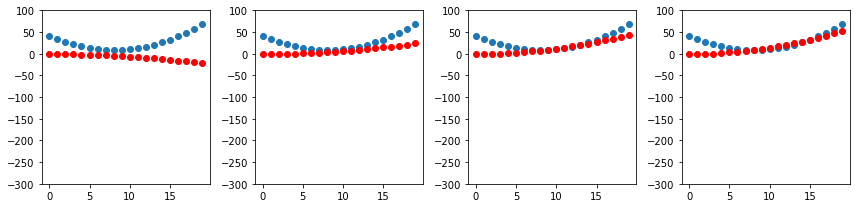

In [15]:
'''
Plotting the function at every step to see how it looks as it approaches the
best quadratic function'''

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params), ax)
plt.tight_layout()


In [16]:
#STEP 7: STOP

'''We've arbitrary stopped after 10 iterations but in practice we would watch our losses and
metrics before we made our decision to stop'''

"We've arbitrary stopped after 10 iterations but in practice we would watch our losses and\nmetrics before we made our decision to stop"

## GOING TO THE REAL DEAL!

In [17]:
#Download/get the dataset and create their tensor
path = untar_data(URLs.MNIST_SAMPLE)
threes = (path/'train/3').ls()
three_tensor = [tensor(Image.open(o)) for o in threes]

sevens = (path/'train/7').ls()
sevens_tensor = [tensor(Image.open(o)) for o in sevens]


In [18]:
#Stacking the picture tensors together
#Stacking the threes and sevens and making the value of the pixels floats of between 0 and 1

stacked_threes = torch.stack(three_tensor).float()/255
stacked_sevens = torch.stack(sevens_tensor).float()/255

In [19]:
#Creating training independent varibles i.e train_x
'''Concatenating our inputs images (stacked_threes, stacked_Sevens) into a single tensor using the
"view" function and also change them from a list of matrices (a rank-3 tensor) to a list of vectors
(a rank-2 tensor)'''
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [20]:
#Creating training dependent varibles i.e train_y

'''Unsqueeze(1) - Adds one dimension on axis 1(y-axis) therefore the dataset takes the shape of
[12396,1]'''

train_y = tensor([1]*len(threes) + [0]*len(sevens))
train_y.shape

torch.Size([12396])

In [21]:
'''1. The zip() function returns a zip object, which is an iterator of tuples where the first item in 
each passed iterator is paired together,and then the second item in each passed iterator are paired 
together etc.'''

'''2. A Dataset in PyTorch is required to return a tuple of (x,y) when indexed.
Python provides a zip function that, when combined with list, provides a simple
way to get this functionality:'''

train_dset = list(zip(train_x, train_y))

In [22]:
path = untar_data(URLs.MNIST_SAMPLE)/'valid'
valid_3s = (path/'3/').ls()
valid_7s = (path/'7/').ls()

valid_3s_tensors = [tensor(Image.open(o)) for o in valid_3s]
valid_7s_tensors = [tensor(Image.open(o)) for o in valid_7s]

stacked_valid_3s = torch.stack(valid_3s_tensors).float()/255
stacked_valid_7s = torch.stack(valid_7s_tensors).float()/255

# cat - Concatenates a sequence of tensor therefore has to be a sequence i.e List, tuple etc
valid_x = torch.cat((stacked_valid_3s,stacked_valid_7s)).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3s) + [0]*len(valid_7s)).unsqueeze(1)

valid_dset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [23]:
#Initialise every pixel with a random weight whose gradient can be retraced and improved

def init_params(size):
    return (torch.randn(size)).requires_grad_()

weights = init_params((28*28, 1))
bias = init_params(1)

In [24]:
first_pred = (train_x[0]*weights) + bias

In [25]:
#Using matrix multiplication to compute the results of all the input rows


def linear(xb):
    return xb@weights + bias

In [26]:
preds = linear(train_x)
preds

tensor([[-15.7293],
        [ -4.4981],
        [ -1.0980],
        ...,
        [  2.2554],
        [  1.7438],
        [-11.6059]], grad_fn=<AddBackward0>)

In [27]:
#Assuming value > 0 = 3 and 7 otherwise
'''Checking our accuracies using broadcasting
'''

correct = (preds > 0).float() == train_y
correct.float().mean()

tensor(0.5030)

In [28]:
'''Prediction using accuracy as the loss function would result into "No learning" since the gradient
of a function usually denoted as rise/run would more often than not result to 0 as illustrated below

grad = (y_new-y_old)/(x_new-x_old)

a slight change in weight would not help much in changing the output of the function hence y_new and 
y_old would result to the same prediction i.e 
 
 y_old - y_new  = 0
 
 grad = 0/(x_new-x_old) = 0(No learning takes place)
 
-We therefore need a function that whenever a weight results to a better prediction would result to 
a better loss function e.g If the correct answer is 3, the score would be a little higher and if 
its 7, the score would go a little lower

The function wouldn't receive the images themselves, rather the predictions from the model which would
be a value between 0 and 1. The targets would either be o for 7s and 1 for 3s. The distance between 
the predictions and targets, aggregated would result to the loss and each time the weight is updated
to the correct direction would result to reduced loss hence "learning"

'''

'Prediction using accuracy as the loss function would result into "No learning" since the gradient\nof a function usually denoted as rise/run would more often than not result to 0 as illustrated below\n\ngrad = (y_new-y_old)/(x_new-x_old)\n\na slight change in weight would not help much in changing the output of the function hence y_new and \ny_old would result to the same prediction i.e \n \n y_old - y_new  = 0\n \n grad = 0/(x_new-x_old) = 0(No learning takes place)\n \n-We therefore need a function that whenever a weight results to a better prediction would result to \na better loss function e.g If the correct answer is 3, the score would be a little higher and if \nits 7, the score would go a little lower\n\nThe function wouldn\'t receive the images themselves, rather the predictions from the model which would\nbe a value between 0 and 1. The targets would either be o for 7s and 1 for 3s. The distance between \nthe predictions and targets, aggregated would result to the loss and ea

In [29]:
#Better function using pytorch's "where" function

'''where in torch works like list comprehension in the form illustrated below
torch.where(a,b,c)  ---->  [b[i] if a[i] else c[i] for i in range(a)]'''

'''One problem with the "mnist_loss" function is that is assumes that the prediction will always
be between 0 and 1. To ensure that this is always the case we use the sigmoid function as defined
below.

PyTorch defines an accelerated version for us, so we don’t really need our own'''

def mnist_loss(prediction, target):
    prediction = prediction.sigmoid()
    return torch.where(target == 1, 1-prediction, prediction).mean()

mnist_loss(preds[:4], train_y[:4])

tensor(0.9346, grad_fn=<MeanBackward0>)

In [30]:
#Simple examples of predictions and targets to test the mnist_loss function
prds = tensor([0.9, 0.1, 0.9])
trgts = tensor([1, 0, 1])

mnist_loss(prds, trgts)

tensor(0.3677)

In [31]:
collection = list(enumerate(string.ascii_lowercase))

In [32]:
#Example of how a DataLoader works using the ASCII characters

'''When we pass a Dataset to a DataLoader we will get back many batches that
are themselves tuples of tensors representing batches of independent and dependent
variables:
'''

dl = DataLoader(collection, batch_size = 5)
list(dl)

[(tensor([0, 1, 2, 3, 4]), ('a', 'b', 'c', 'd', 'e')),
 (tensor([5, 6, 7, 8, 9]), ('f', 'g', 'h', 'i', 'j')),
 (tensor([10, 11, 12, 13, 14]), ('k', 'l', 'm', 'n', 'o')),
 (tensor([15, 16, 17, 18, 19]), ('p', 'q', 'r', 's', 't')),
 (tensor([20, 21, 22, 23, 24]), ('u', 'v', 'w', 'x', 'y')),
 (tensor([25]), ('z',))]

In [33]:
#Creating both the training and valid dataLoaders
training_dl = DataLoader(train_dset, batch_size = 256)
valid_dl = DataLoader(valid_dset, batch_size = 256)

In [34]:
x_data, y_data = first(training_dl)
x_data.shape, y_data.unsqueeze(1).shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [35]:
#Creating a batch that would be used for testing purposes
batch = train_x[:4]

In [36]:
'''The loss function provides a means of automated learning by slghtly improving with slight
change in confidence level after each iteration. It must be a function that must have a meaningful 
derivative in order to facilitate this "learning".It must not have large flat sections and huge 
sudden bumps, rather must be reasonably smooth.

This, sometimes doesn't really express what we are trying to achieve rather a compromise between
our goal and a function that can be optimized by its gradient

The loss function is calculated for each item in our dataset, and
then at the end of an epoch, the loss values are all averaged and the overall mean is
reported for the epoch

Metrics on the other hand are the numbers that we care about e.g is the output a 1 or 0.
And its therefore important that we focus on these metric rather than the loss function
when testing the performance of the model'''

predic = linear(batch)

loss = mnist_loss(predic, train_y[:4])
loss

tensor(0.9346, grad_fn=<MeanBackward0>)

In [37]:
'''Before simplifying the gradient calculations into the "calc_grad" function '''

# def train_epoch(model, params, lr):
#     for xd,yd in training_dl:
#         preds = model(xd)
#         loss = mnist_loss(preds,yd)
#         loss.backward()
        
        
#         for p in params:
#             p.data -= p.grad.data*lr
#             p.grad.zero_()
        

'Before simplifying the gradient calculations into the "calc_grad" function '

In [38]:
def calc_grad(model, x_data, y_data):
    preds = model(x_data)
    loss = mnist_loss(preds,y_data)
    loss.backward()

In [39]:
def train_epoch(model, params, lr):
    for xd,yd in training_dl:
        calc_grad(model, xd, yd)
        
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [40]:
#Function to determine our validation accuracy

'''The "sigmoid()" function squishes values to be between 0 - 1. In this case, values with higher
confidence in their predictions e.g those close to 0 which are supposed to represent 7 have a high
sigmoid function as well as those predictions with values close to 1 and representing 3'''

def batch_accuracy(prediction, y_data):
    preds = prediction.sigmoid()
    correct = (preds > 0.5) == y_data
    return correct.float().mean()

batch_accuracy(linear(batch), train_y[:4])


tensor(0.)

In [41]:
#Putting all the batches together
#Round - Returns a floating-point number rounded off to the specified number of decimals


def validate_epoch(model):
    acc = [batch_accuracy(model(xd), yd) for xd, yd in training_dl]
    return round(torch.stack(acc).mean().item(), 4)

In [42]:
#Parameters for train_epoch
lr = 1
params = weights, bias

In [43]:
#Training for 10 iterations

for i in range(10):
    train_epoch(linear, params, lr)
    print(validate_epoch(linear))

0.7509
0.8764
0.9149
0.9318
0.9411
0.9473
0.952
0.9557
0.9587
0.961


In [44]:
#CREATING AN OPTIMIZER - Create an object that will handle the SGD part for us

'''
nn.Linear does the same thing as our init_params and linear together. It
contains both the weights and biases in a single class. 

CLASS torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)

in_features – size of each input sample

out_features – size of each output sample

bias – If set to False, the layer will not learn an additive bias. Default: True


The values of the 'weight' and 'bias' are initialized from 
-1/in_features.sqrt() --- 1/in_features.sqrt().

The learnable weights of the module is of the shape (out_features,in_features)

The learnable bias of the module is of the shape (out_features)

'''

linear_model = nn.Linear(28*28, 1) #Initializing parameters and would perform linear computations

class BasicOpt:
    def __init__(self, parameters, lr):
        self.params = list(parameters)
        self.lr = lr
    
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None


In [45]:
opt = BasicOpt(linear_model.parameters(), lr)

#Applying the optimizer in our training function

def train_epoch2(model):
    for xd, yd in training_dl: #For independent and dependent vars in DataLoader object
        calc_grad(model, xd, yd) #Calc gradient of the MNIST loss function
        opt.step()
        opt.zero_grad()
        

In [46]:

def train_model(model, epoch):
    for i in range(epoch):
        train_epoch2(model)
        print(validate_epoch(model))
        

In [47]:
train_model(linear_model, 10)

0.4888
0.7445
0.8504
0.9054
0.9308
0.944
0.9519
0.9574
0.9628
0.9666


In [48]:
#Fastai provides us with SGD function that has the same functionality as BasicOpt

linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 10)

0.4888
0.9399
0.7858
0.8871
0.9214
0.9391
0.949
0.9546
0.9606
0.9651


In [49]:
#Fastai also provides us with "Learner.fit()" that can be used in stead of"train_model()"
'''To create a Learner, we need to create a DataLoaders containing the Dataloader of the training
and the valiation dataset

NOTE: DataLoaders - To be used in creating Learner
      DataLoader - Created from input data and output data for training and valid data'''

dls = DataLoaders(training_dl, valid_dl)

In [50]:
'''To create the learner we'll have to pass in all the elements we have created soo far i.e
Learner(dataloaders, model, optimizer_function, loss_function, metric-optional)'''

my_learner = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [51]:
my_learner.fit(10, 1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637428,0.503105,0.495584,00:00
1,0.420727,0.267778,0.751717,00:00
2,0.160808,0.163409,0.854269,00:00
3,0.073817,0.101495,0.916094,00:00
4,0.041665,0.075418,0.935231,00:00
5,0.029008,0.061040,0.947007,00:00
6,0.023697,0.051969,0.955839,00:00
7,0.021251,0.045874,0.962709,00:00
8,0.019954,0.041558,0.965653,00:00
9,0.019143,0.038360,0.967125,00:00


## Using Neural Network instead of a linear Model

In [52]:
'''Linear functions are constrained in what they can do. To improve on the linear functions we
introduce non-linearity between two linear functions. This is what gives us the Neural Network'''

'''2. To make the model more complex such that it can perfom more computations, we introduce
non-linearity whereby a more complex function e.g ReLU is put between two linear classifiers
to form layers that would be our basis for neural networks

The code max(tensor(0.0)) is what we call the RelU which simply replaces all the negative numbers
with a zero'''

def simple_net(xd):
    res = xd@w1 + b1
    res = res.max(tensor(0.0))
    res = xd@w2 + b2
    return res


In [53]:
#MORE INFORMATION ON ITS PARAMETERS AND HOW THEY WORK


w1 = init_params((28*28, 30))
b1 = init_params(1)

w2 = init_params((30, 1))
b2 = init_params(1)

In [54]:
'''The above parameters are the weights and biases that are used in the simple network that are
initially randomly initialized

Importantly to note, w1 has 30 output activations and w2 has 30 input activations and therefore
they match. w1 can therefore construct 30 different features due to different mix of pixels and
one can change the number 30 to any other number to increase or decrease the network's complexity



'''

"The above parameters are the weights and biases that are used in the simple network that are\ninitially randomly initialized\n\nImportantly to note, w1 has 30 output activations and w2 has 30 input activations and therefore\nthey match. w1 can therefore construct 30 different features due to different mix of pixels and\none can change the number 30 to any other number to increase or decrease the network's complexity\n\n\n\n"

In [55]:
#The above can be put into a simpler form with the help of pytorch

simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [56]:
#Replacing the above code with something simpler provided by pytorch

'''nn.sequential creates a module that will call each of the listed layers or functions in turn'''

neural_learner = Learner(dls, simple_net, opt_func=SGD, loss_func = mnist_loss, metrics = batch_accuracy)

neural_learner.fit(40, lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.166191,0.491819,0.504416,00:00
1,0.095126,0.176645,0.832188,00:00
2,0.046297,0.106872,0.900393,00:00
3,0.029080,0.073950,0.930815,00:00
4,0.021636,0.059403,0.943572,00:00
5,0.018124,0.050599,0.951423,00:00
6,0.016168,0.045299,0.957311,00:00
7,0.014869,0.041872,0.961236,00:00
8,0.013944,0.039446,0.962709,00:00
9,0.013195,0.037627,0.962709,00:00


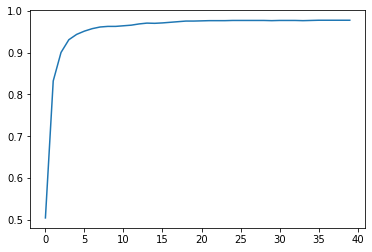

In [57]:
'''ALSO: ; the training process is recorded in "learn.recorder", with the table of output stored in 
the "values" attribute, so we can plot the accuracy over training:

Saving on space from computing the elements as shown above but to get an overview of how learning went
'''
plt.plot(L(neural_learner.recorder.values).itemgot(2));
